In [4]:
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objects as go

In [12]:
vmin = 2
vmax = 20

gdf_data = gpd.read_file(r'Resources\Scenario_dry_ALK_25\hex_cost_components.geojson')


## Hexagon map

In [13]:
# Function to plot the full cost map
def plot_full_cost_map(hexagons, demand_center, cost_column, save_path, provinces=None, vmin=None, vmax=None):
    """
    Plots a map showing production costs in USD/kg with province boundaries.
    
    Parameters:
    - hexagons: GeoDataFrame containing the hexagons and data.
    - demand_center: Name of the demand center (e.g., 'Vientiane').
    - cost_column: The specific column for production cost (e.g., 'Vientiane trucking production cost').
    - save_path: File path to save the PNG image.
    - provinces: GeoDataFrame for province boundaries.
    - vmin: Minimum value for the color scale (optional).
    - vmax: Maximum value for the color scale (optional).
    """
    crs = ccrs.PlateCarree()  # Example projection, adjust as needed
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': crs})
    ax.set_axis_off()

    hexagons_copy = hexagons.copy()

    # Mask zero values
    zero_mask = hexagons_copy[cost_column] == 0
    hexagons_copy.loc[zero_mask, cost_column] = np.nan

    # Plot the province boundaries if provided (this will be below the hexagons)
    if provinces is not None:
        provinces.to_crs(crs.proj4_init).plot(
            ax=ax, color='none', edgecolor='black', linewidth=0.5)

    # Plot the hexagons with production cost, applying the min/max thresholds
    plot = hexagons_copy.to_crs(crs.proj4_init).plot(
        ax=ax,
        column=cost_column,
        legend=True,
        cmap='Greens_r',
        legend_kwds={
            'label': 'Total cost (USD/kgH2)',
            'orientation': 'vertical',
            'shrink': 0.5,
            'pad': 0.05,
            'anchor': (-1.1, 1.0)
        },
        missing_kwds={
            "color": "lightgrey",
            "label": "No Data or Zero",
        },
        edgecolor='black',
        linewidth=0.2,
        vmin=vmin,  # Set the minimum value for the color scale
        vmax=vmax   # Set the maximum value for the color scale
    )

    # Adjust legend position to be on the right side and closer to the center
    if plot.get_legend() is not None:
        legend = plot.get_legend()
        legend.set_bbox_to_anchor((1, 0.5))
        legend.set_frame_on(True)

    plt.show()

    # Save the figure
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)


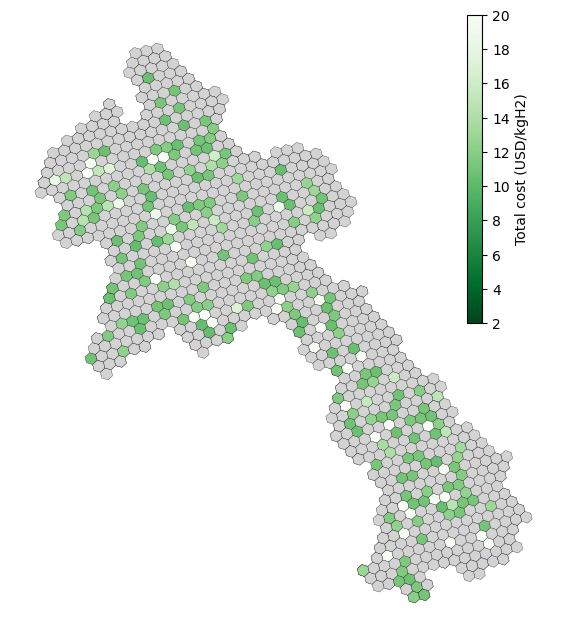

In [15]:
plot_full_cost_map(
    gdf_data, 'Vientiane', 'Vientiane trucking total cost', 
    r'Resources\Scenario_dry_ALK_25\Visualisation\visualisation_lowest_cost.png', 
    vmin=vmin, vmax=vmax
)

## Waterfall Chart

In [16]:
def generate_waterfall_chart(gdf, transport_type):
    # Find the min-cost hexagon in the pipeline or trucking data
    min_hexagon = gdf.loc[gdf[f'Vientiane {transport_type} production cost'].idxmin()]

    # Define the columns for the cost breakdown
    columns = [
        f'Vientiane LCOH - {transport_type} battery costs portion',
        f'Vientiane LCOH - {transport_type} electrolyzer portion',
        f'Vientiane LCOH - {transport_type} H2 storage portion',
        f'Vientiane LCOH - {transport_type} wind portion',
        f'Vientiane LCOH - {transport_type} solar portion',
        f'Vientiane LCOH - {transport_type} hydro portion'
    ]

    # Extract the actual cost values from the selected hexagon
    cost_values = {col: min_hexagon[col] for col in columns}

    # Calculate total LCOH cost for the transport method
    total_cost = min_hexagon[f'Vientiane {transport_type} production cost']

    # Create lists for the waterfall chart
    measures = ["relative"] * len(columns) + ["total"]
    labels = [col.split(" - ")[1].replace(f' {transport_type}', '').replace(' portion', '') for col in columns] + ["Total"]
    values = list(cost_values.values()) + [0]  # 0 for total, as it will be auto-calculated
    texts = [f"{value:.2f}" for value in cost_values.values()] + [f"{total_cost:.2f}"]

    # Create the waterfall chart with improved aesthetics
    fig = go.Figure(go.Waterfall(
        name="LCOH Cost Breakdown",  # Removed transport type from title
        orientation="v",
        measure=measures,
        x=labels,
        y=values,
        text=texts,
        connector={"line": {"color": "rgb(63, 63, 63)", "dash": "dot"}},
        increasing={"marker": {"color": "#0000ff"}},  # Blue color for increasing
        decreasing={"marker": {"color": "#ff7f0e"}},  # Orange color for decreasing
        totals={"marker": {"color": "#000000"}}  # Black color for total
    ))

    # Update layout to increase font sizes and improve the overall look
    fig.update_layout(
        title=f"{transport_type.capitalize()} LCOH Cost Breakdown",
        xaxis_title="Cost Portions",
        yaxis_title="LCOH [USD/kgH2]",
        xaxis=dict(
            tickfont=dict(color='black', size=20),  # Increased x-axis tick labels font size
            titlefont=dict(color='black', size=22),  # Increased x-axis title font size
        ),
        yaxis=dict(
            tickfont=dict(color='black', size=20),  # Increased y-axis tick labels font size
            titlefont=dict(color='black', size=22),  # Increased y-axis title font size
            showgrid=True,
            gridcolor='lightgrey'  # Light grey grid lines for y-axis
        ),
        plot_bgcolor='white',  # Set plot background color to white
        showlegend=False,
        width=900,
        height=600,
        font=dict(size=18),  # General font size increase
        margin=dict(l=50, r=50, t=100, b=50)
    )

    # Show the plot
    fig.show()

In [17]:
generate_waterfall_chart(gdf_data, 'pipeline')